# Homework 2

## Item-1

### Use KNN classification

#### Objective:
Implement and try a KNN classification model
#### Steps:
 * Create clusters with scikit-learn (make_blobs function)
 * Perform KNN classification on these
 * Determine a good value for k and explain your choice

In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

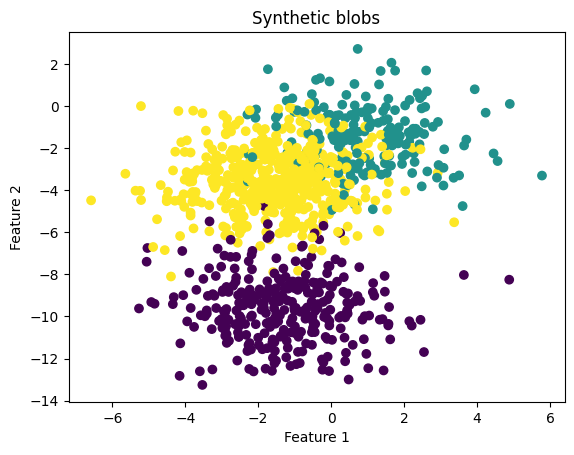

In [3]:
X, y = make_blobs(
    n_samples=[300, 200, 500],      # total number of points
    n_features=2,       # dimensions (2D so we can plot)
    cluster_std=1.5,    # spread of each cluster
    random_state=2     # reproducible results
)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Synthetic blobs")
plt.show()

### k-NN is distance-based ⇒ features must be on similar scales.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# X: features
# y: class labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y  # use stratify when classes are imbalanced
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

Basic k-NN classifier

In [5]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors=5,      # k
    weights='uniform',  # or 'distance'
    metric='minkowski', # default (p=2 → Euclidean)
    p=2
)

knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

Evaluate the model

In [6]:
# Use accuracy + confusion matrix (and F1 if imbalanced):
from sklearn.metrics import accuracy_score, confusion_matrix

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.895
[[54  0  6]
 [ 0 32  8]
 [ 1  6 93]]


Determining Best K

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

param_grid = {
    "knn__n_neighbors": [1, 3, 6, 7, 8, 11, 15],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]  # 1=Manhattan, 2=Euclidean
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print(f'Best CV score: {grid.best_score_:.3f}')

best_model = grid.best_estimator_
test_acc = best_model.score(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')


Best params: {'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'uniform'}
Best CV score: 0.906
Test accuracy: 0.905


By using cross-validation + GridSearchCV we obtained a test accuracy of 90.5% which was previously 89.5%.

## Item-2

### Use K means and DBSCAN clustering

#### Objective:
Implement and try a K means and DBSCAN clustering models
#### Steps:
 * Create clusters with scikit-learn (make_blobs function)
 * Perform clustering on these
 * Show your result

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Configuration
n_samples = 500  # Total number of data points
n_features = 2   # Number of dimensions (e.g., x and y coordinates)
n_clusters = 3   # The known number of clusters we want to generate
random_state = 2 # For reproducible results

In [9]:
# Data Generation
# X contains the features (coordinates), y_true contains the true cluster labels
X, y_true = make_blobs(
    n_samples=n_samples,
    centers=n_clusters,
    n_features=n_features,
    cluster_std=1.2, # Standard deviation of the clusters (controls how spread out they are)
    random_state=random_state
)

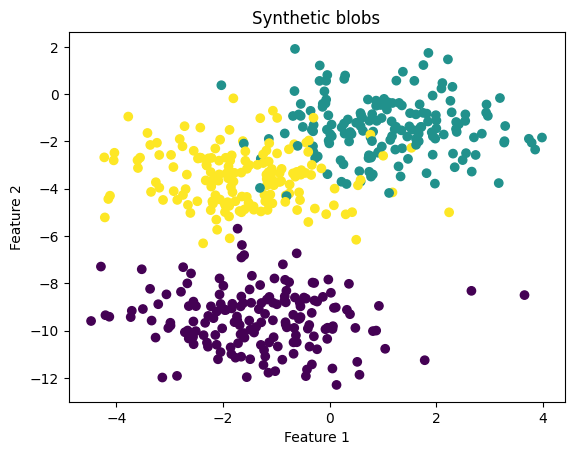

In [10]:
plt.scatter(X[:, 0], X[:, 1], c=y_true)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Synthetic blobs")
plt.show()

**KMeans Clustering**

In [11]:
# K-Means Initialization and Fitting
kmeans = KMeans(
    n_clusters=n_clusters,
    init='k-means++', # Smart initialization method to speed up convergence
    max_iter=1000,
    random_state=random_state,
    n_init='auto' # Automatically set the number of initializations
)

# Fit the model to the data
kmeans.fit(X)

# Get the cluster assignments (labels) and the final centroid coordinates
y_kmeans = kmeans.predict(X)
centers = kmeans.cluster_centers_

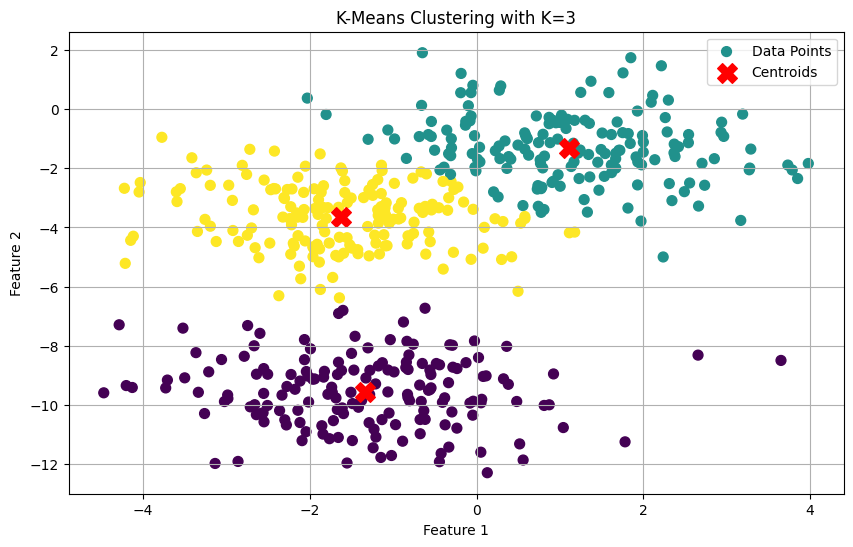

In [12]:
# Visualization
plt.figure(figsize=(10, 6))

# Plot the data points, colored by the predicted cluster label
plt.scatter(
    X[:, 0], X[:, 1],
    c=y_kmeans,
    s=50, # Marker size
    cmap='viridis',
    label='Data Points'
)

# Plot the centroids
plt.scatter(
    centers[:, 0], centers[:, 1],
    c='red',
    s=200, # Larger size for centers
    marker='X',
    label='Centroids'
)

plt.title(f"K-Means Clustering with K={n_clusters}")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()
#

* The example above works perfectly because we knew the correct number of clusters (4) since we generated the data ourselves.
* In real-world R&D problems, you won't know the true number of clusters. This is where the Elbow Method comes in. 
* You run K-means for a range of $k$ values (e.g., $k=1$ to $10$) and calculate the Within-Cluster Sum of Squares (WCSS), also known as Inertia. WCSS measures how compact the clusters are.

**Evaluating KMeans Classification**
- ARI (Adjusted Rand Index): 1 = perfect, ~0 = random, -1 = worst than random
- NMI (Normalized Mutual Info): 1= perfect, 0 = random

In [13]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Only possible because we generated the data ourselves!
score1 = adjusted_rand_score(y_true, y_kmeans)
score2 = normalized_mutual_info_score(y_true, y_kmeans)
print(f"Adjusted Rand Index: {score1:.2f}") 
print(f"Normalized Mutual Information: {score2:.2f}")

Adjusted Rand Index: 0.85
Normalized Mutual Information: 0.82


Notes for evaluating unsupervised learning models:

* Classification Evaluation: Uses "Accuracy/F1". Requires labels. (Not for K-Means).

* External Clustering Evaluation: Uses "Adjusted Rand Index". Requires labels (Only for testing/learning).

* Internal Clustering Evaluation: Uses "Silhouette Score" or "Inertia". Does not require labels. (This is the standard tool for real work).

**DBSCAN Clustering**

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

In [15]:
# Same data generation as before
X_blobs, y_blobs = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n_features, cluster_std=1.2, random_state=random_state)

In [16]:
# Preprocessing (CRITICAL for DBSCAN)
# DBSCAN calculates distances, so if one axis is 1000 and the other is 0.1, it breaks.
scaler = StandardScaler()
X_blobs_scaled = scaler.fit_transform(X_blobs)

In [17]:
# Apply DBSCAN
# eps= : The maximum distance between two samples for one to be considered as in the neighborhood of the other.
# min_samples= : The number of samples in a neighborhood for a point to be considered a core point.
dbscan = DBSCAN(eps=0.25, min_samples=5)
y_dbscan = dbscan.fit_predict(X_blobs_scaled)

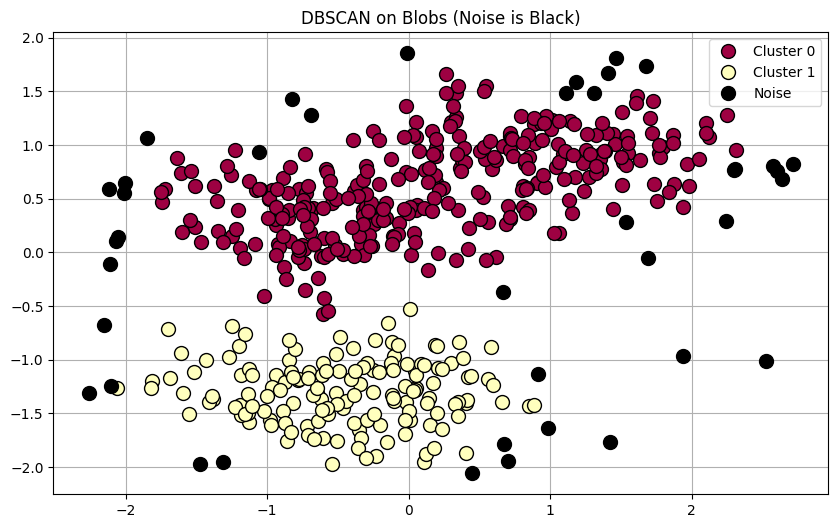

In [18]:
# Visualization
plt.figure(figsize=(10, 6))

# Note: DBSCAN labels noise as -1
unique_labels = set(y_dbscan)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        label = "Noise"
    else:
        label = f"Cluster {k}"

    class_member_mask = (y_dbscan == k)
    
    xy = X_blobs_scaled[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10, label=label)

plt.title('DBSCAN on Blobs (Noise is Black)')
plt.legend()
plt.grid(True)
plt.show()


Observation: DBSCAN behaves very similarly to K-Means
* Its advantage: it might identify "outliers" (black dots) that don't belong to any cluster, whereas K-Means would force them into the nearest cluster.
* A disadvantage as seen in the plot DBSAN may combine two differenet cluster into one if they are close, mixed and have simialar densities.

**The Real R&D Comparison: When K-Means Fails**

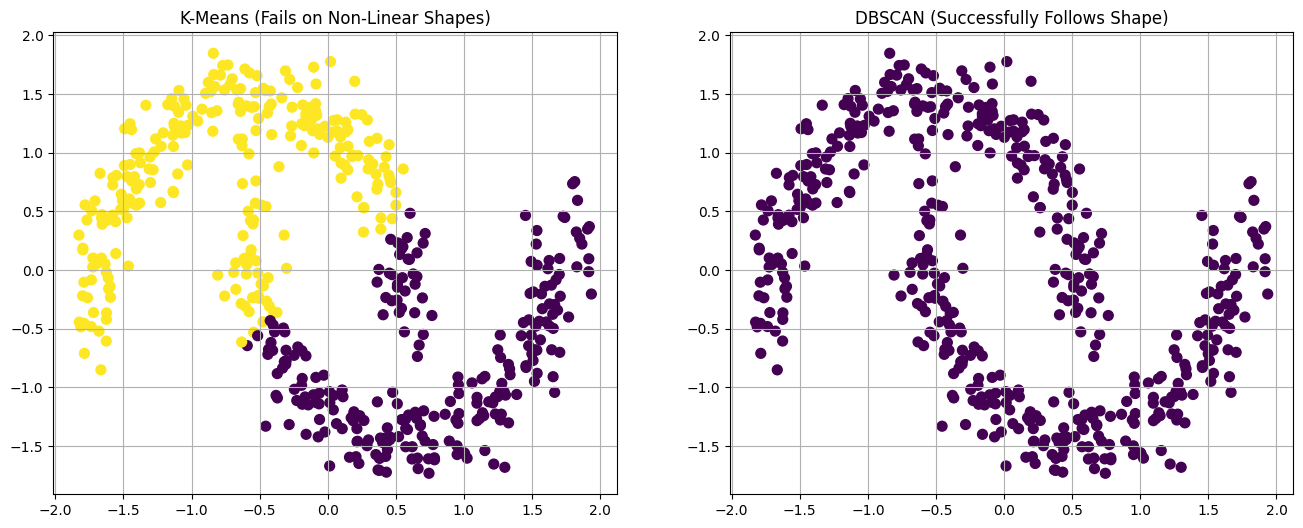

In [19]:
# 1. Generate "Moons" Data (Non-linear shapes)
X_moons, _ = make_moons(n_samples=500, noise=0.1, random_state=2)
X_moons_scaled = StandardScaler().fit_transform(X_moons)

# 2. Model 1: K-Means (The "Naive" Approach)
kmeans = KMeans(n_clusters=2, n_init='auto', random_state=2)
y_km_moons = kmeans.fit_predict(X_moons_scaled)

# 3. Model 2: DBSCAN (The "Density" Approach)
dbscan = DBSCAN(eps=0.3, min_samples=5)
y_db_moons = dbscan.fit_predict(X_moons_scaled)

# 4. Side-by-Side Comparison Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# K-Means Plot
ax1.scatter(X_moons_scaled[:, 0], X_moons_scaled[:, 1], c=y_km_moons, cmap='viridis', s=50)
ax1.set_title("K-Means (Fails on Non-Linear Shapes)")
ax1.grid(True)

# DBSCAN Plot
# Handle noise color manually if needed, but for simple scatter 'c' handles it reasonably
ax2.scatter(X_moons_scaled[:, 0], X_moons_scaled[:, 1], c=y_db_moons, cmap='viridis', s=50)
ax2.set_title("DBSCAN (Successfully Follows Shape)")
ax2.grid(True)

plt.show()
#

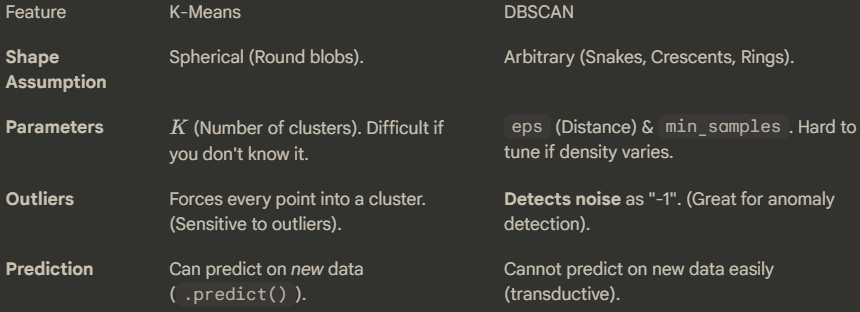

Practical Tip: If you are analyzing vibration sensor data (common in ME), use DBSCAN to filter out "noise" (sensor errors) automatically. If you are grouping customer types for a bank, K-Means is usually sufficient and easier to explain to business managers.

## Item-3

### Build your own dataset from NOMAD

#### Objective:
Create a dataset of at least 1000 and less than 10000 entries with at least 3 
descriptors and 1 target quantity
#### Steps:
 * Decide on descriptors and target quantities on the website
 * Use the API to download the data
 * Collect it in a dataframe

In [53]:
import requests
import pandas as pd
import time
import re

In [60]:
# Helper to fix missing N_Atoms
def calculate_atoms(formula):
    if pd.isna(formula) or formula == 'Unknown': return 0
    matches = re.findall(r'([A-Z][a-z]*)(\d*)', str(formula))
    total = 0
    for _, count in matches:
        total += int(count) if count else 1
    return total

In [61]:
# Configuration
url = "https://nomad-lab.eu/prod/v1/api/v1/entries/archive/query"
target_count = 1000
page_size = 100  
data_list = []
next_page_token = None

print(f"Starting optimized download of {target_count} Bulk entries with DOS & Band Gap...")

while len(data_list) < target_count:
    
    # Optimized Payload
    json_payload = {
        "query": {
            "results.material.structural_type:any": ["bulk"],
            "results.properties.available_properties:all": [
                "dos_electronic", 
                "electronic.band_structure_electronic.band_gap"
            ]
        },
        "pagination": {
            "page_size": page_size,
            "page_after_value": next_page_token
        },
        "required": {
            "results": {
                "material": "*",
                "properties": {
                    "electronic": {
                        "band_structure_electronic": {
                            "band_gap": "*"
                        }
                    }
                }
            }
        }
    }

    try:
        response = requests.post(url, json=json_payload)
        
        if response.status_code != 200:
            print(f"Error {response.status_code}: {response.text[:200]}")
            break
            
        response_json = response.json()
        batch_data = response_json['data']
        
        if not batch_data:
            print("End of database results.")
            break
        
        next_page_token = response_json['pagination'].get('next_page_after_value')

        # Processing
        current_batch_valid = 0
        for item in batch_data:
            try:
                entry = item['archive']
                mat = entry['results']['material']
                elec = entry['results']['properties']['electronic']
                
                # Extract Band Gap
                bs = elec['band_structure_electronic'][0]
                if 'band_gap' not in bs or not bs['band_gap']: continue
                bg_val = bs['band_gap'][0].get('value')
                if bg_val is None: continue

                # Extract Descriptors
                formula = mat.get('chemical_formula_hill', 'Unknown')
                crystal = mat.get('symmetry', {}).get('crystal_system', 'Unknown')
                n_atoms = mat.get('n_atoms', 0)

                data_list.append({
                    "Entry_ID": item['entry_id'],
                    "Formula": formula,
                    "Crystal_System": crystal,
                    "N_Atoms": n_atoms,
                    "Band_Gap_eV": bg_val * 6.241509 
                })
                current_batch_valid += 1
                
            except Exception:
                continue
        
        print(f"Batch processed. Total valid items: {len(data_list)}")
        
        if len(data_list) >= target_count:
            break
        if not next_page_token:
            break
            
        # Minimized sleep for speed
        time.sleep(0.1)
        
    except Exception as e:
        print(f"Network Error: {e}")
        break

Starting optimized download of 1000 Bulk entries with DOS & Band Gap...
Batch processed. Total valid items: 32
Batch processed. Total valid items: 62
Batch processed. Total valid items: 104
Batch processed. Total valid items: 145
Batch processed. Total valid items: 178
Batch processed. Total valid items: 228
Batch processed. Total valid items: 270
Batch processed. Total valid items: 310
Batch processed. Total valid items: 348
Batch processed. Total valid items: 379
Batch processed. Total valid items: 430
Batch processed. Total valid items: 464
Batch processed. Total valid items: 500
Batch processed. Total valid items: 545
Batch processed. Total valid items: 579
Batch processed. Total valid items: 619
Batch processed. Total valid items: 652
Batch processed. Total valid items: 691
Batch processed. Total valid items: 734
Batch processed. Total valid items: 775
Batch processed. Total valid items: 813
Batch processed. Total valid items: 852
Batch processed. Total valid items: 889
Batch proc

In [64]:
# DataFrame & Cleaning
df = pd.DataFrame(data_list)

if not df.empty:
    # Recalculate N_Atoms if missing
    df['N_Atoms'] = df['Formula'].apply(calculate_atoms)
    
    # Remove bad rows
    df = df[df['N_Atoms'] > 0]
    df = df[df['Crystal_System'] != 'Unknown']
    
    # Enforce limit
    if len(df) > 10000:
        df = df.head(10000)

print(f"Final Dataset Size: {len(df)} entries.")

Final Dataset Size: 1003 entries.


In [65]:
print(df.head(5))

                       Entry_ID Formula Crystal_System  N_Atoms   Band_Gap_eV
0  --ANBlttp-XmYR5rofGoJCO4eDRJ   N4Tm4          cubic        8  0.000000e+00
1  --Hz0U6YpO691ha6_CatQ0KrhOjJ   Ca4O4          cubic        8  3.637760e-18
2  --R93zuGzaoApcgoCHfvHbqu8TGc   Cd4O4          cubic        8  0.000000e+00
3  --VaaYRF9sqJWhCtztQp8U-4rE-5   O3Pm2       trigonal        5  0.000000e+00
4  --b--AqROml19cw86rZ748lzPkQY    ClCs          cubic        2  5.307960e-18


**Quick EDA Plots**

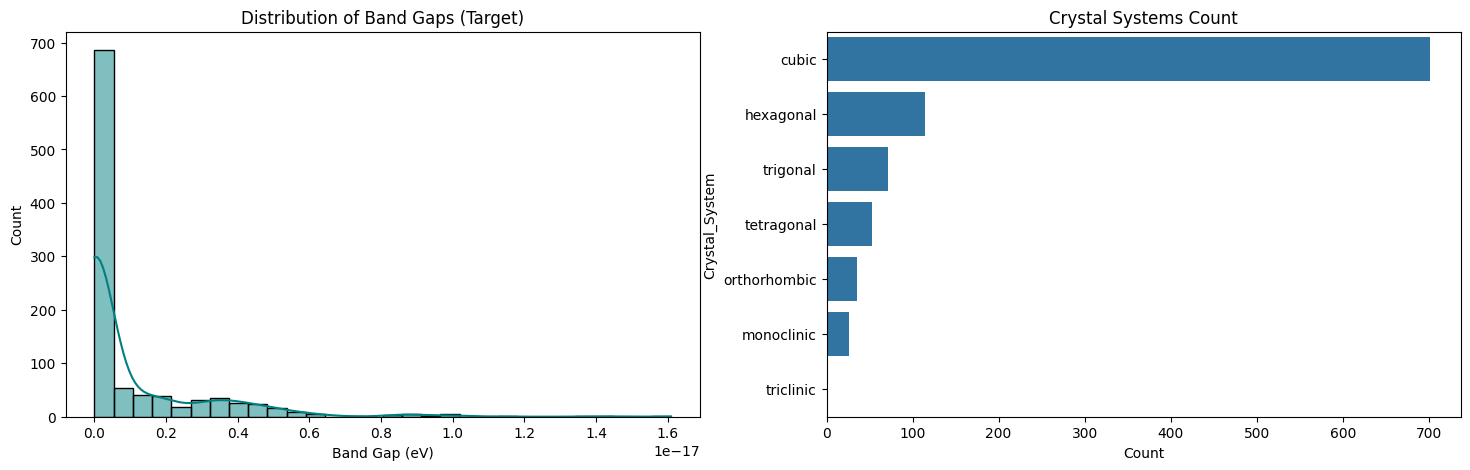

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
# Plot A: Target Distribution (Is it balanced?)
sns.histplot(df['Band_Gap_eV'], bins=30, kde=True, ax=axes[0], color='teal')
axes[0].set_title('Distribution of Band Gaps (Target)')
axes[0].set_xlabel('Band Gap (eV)')
# Plot B: Categorical Descriptor (Do we have variety?)
sns.countplot(y=df['Crystal_System'], ax=axes[1], order=df['Crystal_System'].value_counts().index)
axes[1].set_title('Crystal Systems Count')
axes[1].set_xlabel('Count')
plt.show()

## Item-4

### Perform SVM on the Binary Classification Dataset

#### Objective:
Implement and try SVM
#### Steps:
 * Read the dataset
 * Perform SVM using the polynomial kernel
 * Optimize the d (degree) parameter using CV
 * Try the RBF kernel

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Read Data
df=pd.read_csv(r"C:\Users\ayber\OneDrive\Masaüstü\ML\Data\external\Fatigue_data.csv").copy()
target='Fatigue'

# Prepare X and y
X = df.drop(columns=['Sl. No.', target]).copy()
y_reg = df[target].to_numpy()
y = (y_reg > 500).astype(int)     # 1=Good Fatigue Life, 0=Bad

pd.Series(y).value_counts()

1    233
0    204
Name: count, dtype: int64

In [86]:
# Split and Scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Polynomial Kernel with CV to optimize Degree (d)**

In [97]:
print("\n--- Optimizing Polynomial Kernel (Degree) ---")

# Define the model and parameter grid
svc_poly = SVC(kernel='poly', coef0=1) # coef0=1 is important for poly kernels to work well
param_grid = {'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# Grid Search with Cross Validation (CV=5)
grid_poly = GridSearchCV(svc_poly, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_poly.fit(X_train_scaled, y_train)

print(f"Best Degree found: {grid_poly.best_params_['degree']}")
print(f"Best CV Accuracy: {grid_poly.best_score_:.3f}")


--- Optimizing Polynomial Kernel (Degree) ---
Best Degree found: 7
Best CV Accuracy: 0.943


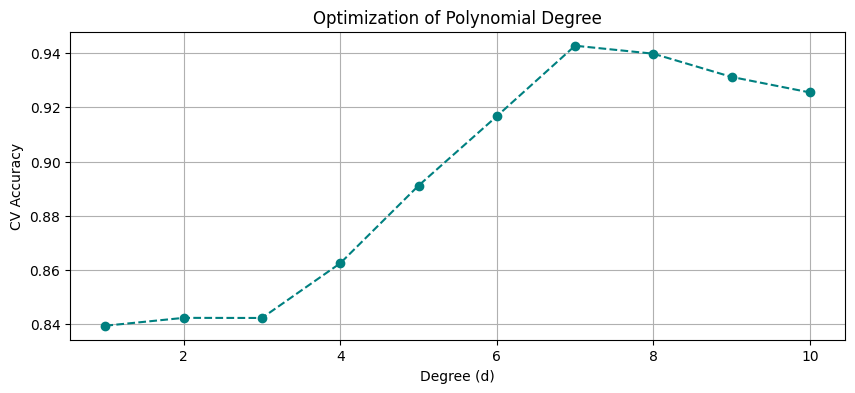

In [98]:
degrees = param_grid['degree']
scores = grid_poly.cv_results_['mean_test_score']

plt.figure(figsize=(10, 4))
plt.plot(degrees, scores, marker='o', linestyle='--', color='teal')
plt.title("Optimization of Polynomial Degree")
plt.xlabel("Degree (d)")
plt.ylabel("CV Accuracy")
plt.grid(True)
plt.show()

In [99]:
# Evaluate on Test Set using the best degree
best_poly_model = grid_poly.best_estimator_
y_pred_poly = best_poly_model.predict(X_test_scaled)
print(f"Polynomial Test Accuracy: {accuracy_score(y_test, y_pred_poly):.3f}")

Polynomial Test Accuracy: 0.864


**Try the RBF Kernel**

In [100]:
# RBF is usually the default because it handles infinite dimensions
svc_rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
svc_rbf.fit(X_train_scaled, y_train)

y_pred_rbf = svc_rbf.predict(X_test_scaled)
rbf_acc = accuracy_score(y_test, y_pred_rbf)

print(f"RBF Test Accuracy: {rbf_acc:.3f}")
print("\nRBF Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rbf))

RBF Test Accuracy: 0.795

RBF Confusion Matrix:
[[30 14]
 [ 4 40]]


## Item-5

### Compute Accuracy

#### Objective:
Compute accuracy yourself
#### Steps:
 * Read the dataset
 * Perform logistic regression
 * Compute accuracy for 0.5 threshold

In [102]:
from sklearn.linear_model import LogisticRegression

In [104]:
# Logistic Regression
# solver='liblinear' is often good for small datasets
log_reg = LogisticRegression(random_state=2, solver='liblinear')
log_reg.fit(X_train_scaled, y_train)

# Predict (Default Threshold is 0.5)
# This function automatically assigns 1 if Probability > 0.5, else 0
y_pred = log_reg.predict(X_test_scaled)

**Compute Accuracy Manually**

In [109]:
# A. Check which predictions match the actual values (Returns array of True/False)
correct_predictions_mask = (y_test == y_pred)

# B. Count the "True" values
num_correct = np.sum(correct_predictions_mask)

# C. Get total number of samples
total_samples = len(y_test)

# D. Calculate Formula
manual_accuracy = num_correct / total_samples

print(f"Manual Calculation")
print(f"Correct Predictions : {num_correct}")
print(f"Total Predictions   : {total_samples}")
print(f"Calculated Accuracy : {manual_accuracy:.4f} ({manual_accuracy*100:.2f}%)")

Manual Calculation
Correct Predictions : 75
Total Predictions   : 88
Calculated Accuracy : 0.8523 (85.23%)


In [111]:
# Verification using sklearn
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_test, y_pred)
print(f"\nVerification")
print(f"Sklearn Accuracy: {sklearn_accuracy:.4f}")


Verification
Sklearn Accuracy: 0.8523


## Item-6

### Compute Confusion Matrix

#### Objective:
 Compute confusion matrix for your model
#### Steps:
 * Compute confusion matrix…

In [112]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

* True Positive (TP): Actual is 1 (Good), Predicted is 1 (Good).

* True Negative (TN): Actual is 0 (Bad), Predicted is 0 (Bad).

* False Positive (FP): Actual is 0 (Bad), but Model said 1 (Good). Dangerous in engineering!

* False Negative (FN): Actual is 1 (Good), but Model said 0 (Bad). Conservative/Safe error.

**Manual Calculation**

In [114]:
# We compare the arrays element-wise
TP = np.sum((y_test == 1) & (y_pred == 1))
TN = np.sum((y_test == 0) & (y_pred == 0))
FP = np.sum((y_test == 0) & (y_pred == 1)) # Model cried wolf (Type I Error)
FN = np.sum((y_test == 1) & (y_pred == 0)) # Model missed the signal (Type II Error)

print("--- Manual Confusion Matrix ---")
print(f"True Positives  (TP): {TP}")
print(f"True Negatives  (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

# Construct the matrix (Standard format: Rows=Actual, Cols=Predicted)
manual_cm = np.array([[TN, FP],
                      [FN, TP]])

print("\nMatrix Form (Actual vs Predicted):")
print(manual_cm)

--- Manual Confusion Matrix ---
True Positives  (TP): 40
True Negatives  (TN): 35
False Positives (FP): 9
False Negatives (FN): 4

Matrix Form (Actual vs Predicted):
[[35  9]
 [ 4 40]]


**Library Verification & Visualization**


--- Sklearn Verification ---
[[35  9]
 [ 4 40]]


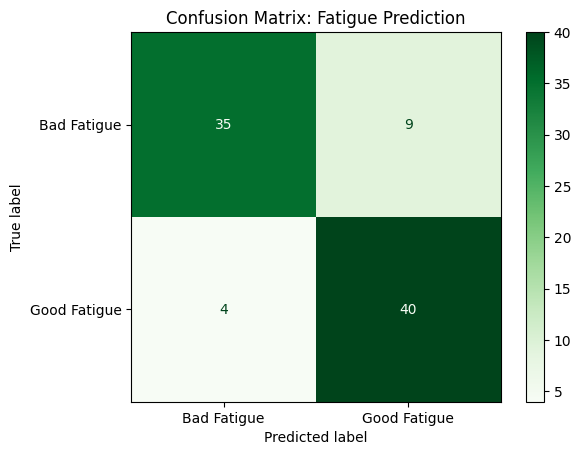

In [121]:
print("\n--- Sklearn Verification ---")
sklearn_cm = confusion_matrix(y_test, y_pred)
print(sklearn_cm)

# Visualization 
disp = ConfusionMatrixDisplay(confusion_matrix=sklearn_cm, display_labels=['Bad Fatigue', 'Good Fatigue'])
disp.plot(cmap='Greens')
plt.title("Confusion Matrix: Fatigue Prediction")
plt.show()

**Engineering Interpretation**

For Fatigue analysis:

- High Accuracy is not enough.

* If False Positives (FP) are high: We are predicting a part will last long (Good), but it actually fails early (Bad). This causes catastrophic failure.

* If False Negatives (FN) are high: We predict it will fail early, but it lasts long. You replace parts too early. This costs money, but is safe.

## Item-7

### Implement ROC and AUC in Python

#### Objective:
Implement and compute ROC and AUC
#### Steps:
 * Read the dataset (fatigue)
 * Perform classification (binary classification)
 * Compute the ROC and AUC metrics

In [124]:
X = df.drop(columns=['Sl. No.', target]).copy()
# Binary Classification: 1 = High Fatigue Life (>500), 0 = Low
y = (df[target] > 500).astype(int) 

# 2. Split and Scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Train Model (Logistic Regression is great for probabilities)
model = LogisticRegression(random_state=2, solver='liblinear')
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,2
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


**Compute ROC and AUC**

In [126]:
from sklearn.metrics import roc_curve, roc_auc_score

In [135]:
# A. Get Probabilities
# .predict_proba returns [Prob of Class 0, Prob of Class 1]
# We only need the probability of the Positive class (Class 1)
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# B. Calculate ROC Curve inputs
# fpr = False Positive Rate, tpr = True Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# C. Calculate AUC Score (Single number summary)
auc_score = roc_auc_score(y_test, y_probs)

print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.9711


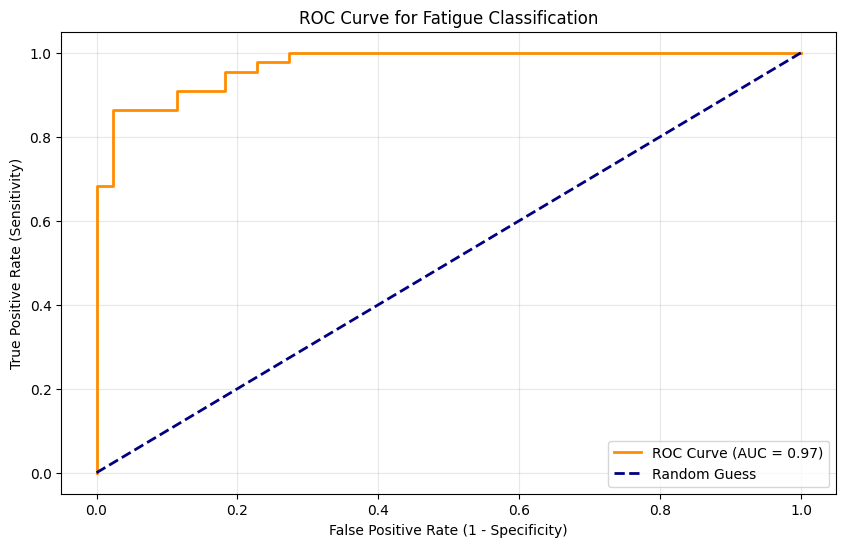

In [133]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot the Model's Curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')

# Plot the "Random Guess" line (Diagonal)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve for Fatigue Classification')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

## Item-8

### Implement a GPR

#### Objective:
 Train a GPR using scikit-learn on the Fatigue dataset
#### Steps:
 * Train your regressor
 * Characterize the accuracy

In [137]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.metrics import mean_squared_error, r2_score

In [138]:
X = df.drop(columns=['Sl. No.', target]).copy()
y = df[target].to_numpy() 

# GPR is distance-based; unscaled data will break the kernel optimization.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [148]:
# Define the Kernel
# Standard Kernel: RBF (Smoothness) + WhiteKernel (Noise)
# ConstantKernel (C) allows the model to adjust vertical scale.
# WhiteKernel is CRITICAL: It tells the model "Data has experimental noise, don't overfit."
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# Train the Regressor
# normalize_y=True handles target scaling automatically
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True, random_state=42)
gpr.fit(X_train_scaled, y_train)

# Characterize Accuracy
# GPR allows us to predict the Mean AND the Standard Deviation (Uncertainty)
y_pred, y_std = gpr.predict(X_test_scaled, return_std=True)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Performance")
print(f"Optimal Kernel: {gpr.kernel_}")
print(f"RMSE: {rmse:.2f} (Average error in Fatigue units)")
print(f"R2 Score: {r2:.3f}")

Model Performance
Optimal Kernel: 2.26**2 * RBF(length_scale=9.99) + WhiteKernel(noise_level=0.00833)
RMSE: 19.14 (Average error in Fatigue units)
R2 Score: 0.989


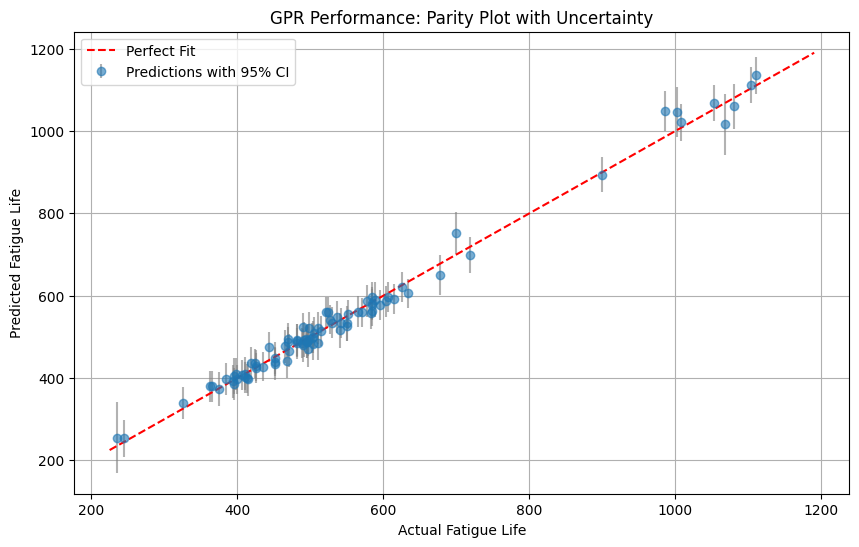

In [147]:
# Visualization: Parity Plot with Uncertainty Bars
plt.figure(figsize=(10, 6))

# Plot actual vs predicted with error bars (Confidence Intervals)
# We use 1.96 * std for 95% confidence interval
plt.errorbar(y_test, y_pred, yerr=1.96*y_std, fmt='o', alpha=0.6, 
             ecolor='gray', label='Predictions with 95% CI')

# Perfect prediction line
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Fit')

plt.xlabel("Actual Fatigue Life")
plt.ylabel("Predicted Fatigue Life")
plt.title("GPR Performance: Parity Plot with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

## Item-9

### Implement a Decision Tree

#### Objective:
 Train a tree using scikit-learn on the binary “Fatigue” (good vs. bad) data set
#### Steps:
 * Read the dataset
 * Train your classifier
 * Predict for validation dataset and compute AUC for training and validation 
dataset

In [149]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

Unlike SVM or GPR, Decision Trees do not require feature scaling (StandardScaler). They split data based on raw values, which makes them very easy to interpret.

In [150]:
X = df.drop(columns=['Sl. No.', target]).copy()
y = (df[target] > 500).astype(int) # 1=Good (>500), 0=Bad
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

In [153]:
# Train the Classifier
# max_depth=3: Limits depth to prevent overfitting and keep the tree readable
clf = DecisionTreeClassifier(max_depth=3, random_state=2) 
clf.fit(X_train, y_train)

# Compute AUC (Area Under Curve)
# Critical: AUC requires probabilities (.predict_proba), not just class labels
# [:, 1] extracts the probability of the "Positive" class (1: Good Fatigue)
prob_train = clf.predict_proba(X_train)[:, 1]
prob_val   = clf.predict_proba(X_val)[:, 1]

auc_train = roc_auc_score(y_train, prob_train)
auc_val   = roc_auc_score(y_val, prob_val)

print("Model Performance")
print(f"Training AUC   : {auc_train:.4f}")
print(f"Validation AUC : {auc_val:.4f}")

Model Performance
Training AUC   : 0.9829
Validation AUC : 0.9569


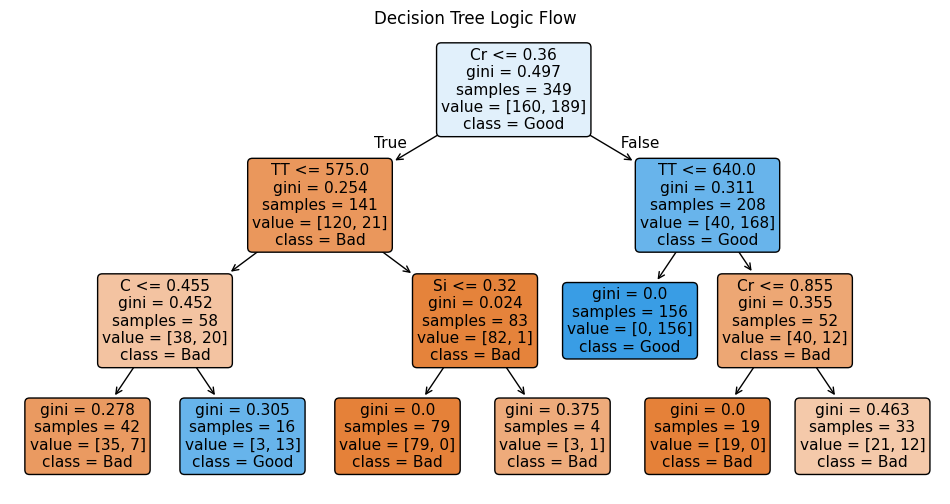

In [154]:
# Visualization
# This is the main advantage of Trees: You can see the physical logic
plt.figure(figsize=(12, 6))
plot_tree(clf, 
          feature_names=X.columns, 
          class_names=['Bad', 'Good'], 
          filled=True, 
          rounded=True)
plt.title("Decision Tree Logic Flow")
plt.show()

**Engineering Insight**
* Overfitting Check: Compare your Training AUC and Validation AUC. If Training is 1.00 but Validation is 0.70, your tree has "memorized" the data. Reducing max_depth forces the model to learn general rules instead of specific data points.

* Root Node: The feature at the very top of the tree (e.g., "Cr < 0.36") is the most important variable in determining fatigue life.